In [30]:
import numpy as np
import pandas as pd
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchinfo import summary
from ISLP.torch import SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from matplotlib.pyplot import subplots
from sklearn.linear_model import (LinearRegression, LogisticRegression, Lasso)

In [15]:
Default = load_data('Default')
Default['student'] = Default.student.map(dict(Yes=1,No=0))
Default['default'] = Default.default.map(dict(Yes=1,No=0))
Default.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [3]:
model = MS(Default.columns.drop('default'), intercept=False)
# Convert pandas dfs to numpy arrays
X = model.fit_transform(Default).to_numpy()
Y = Default['default'].to_numpy() 

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=1/3,
                                                    random_state=1)

In [5]:
class DefaultModel(nn.Module):
    def __init__(self, input_size):
        super(DefaultModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(10, 2))
    def forward(self, x):
        x = self.flatten(x)
        return self.sequential(x)

In [6]:
default_model = DefaultModel(X.shape[1])
summary(default_model,
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DefaultModel                             [6666, 3]                 [6666, 2]                 --
├─Flatten: 1-1                           [6666, 3]                 [6666, 3]                 --
├─Sequential: 1-2                        [6666, 3]                 [6666, 2]                 --
│    └─Linear: 2-1                       [6666, 3]                 [6666, 10]                40
│    └─ReLU: 2-2                         [6666, 10]                [6666, 10]                --
│    └─Dropout: 2-3                      [6666, 10]                [6666, 10]                --
│    └─Linear: 2-4                       [6666, 10]                [6666, 2]                 22
Total params: 62
Trainable params: 62
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.41
Input size (MB): 0.08
Forward/backward pass size (MB): 0.64
Params size (MB): 0.00
Estimated Total Size (MB): 0.72

In [7]:
# Tranform data to be accessible to torch ( 32-bit tensors)
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
def_train = TensorDataset(X_train_t, Y_train_t)

X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
def_test = TensorDataset(X_test_t, Y_test_t)

In [22]:
max_num_workers = rec_num_workers()
def_dm = SimpleDataModule(def_train,
                          def_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=0.2)

In [23]:
def_module = SimpleModule.classification(default_model, num_classes=2)
def_logger = CSVLogger('logs', name='Default')

default_trainer = Trainer(deterministic=True,
                          max_epochs=40,
                          logger=def_logger,
                          callbacks=[ErrorTracker()],
                         accelerator='mps')
default_trainer.fit(def_module,
                    datamodule=def_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DefaultModel     | 62     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
62        Trainable params
0         Non-trainable params
62        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [26]:
# Plotting function
def summary_plot(results,
                 ax, 
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black', 'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        return ax

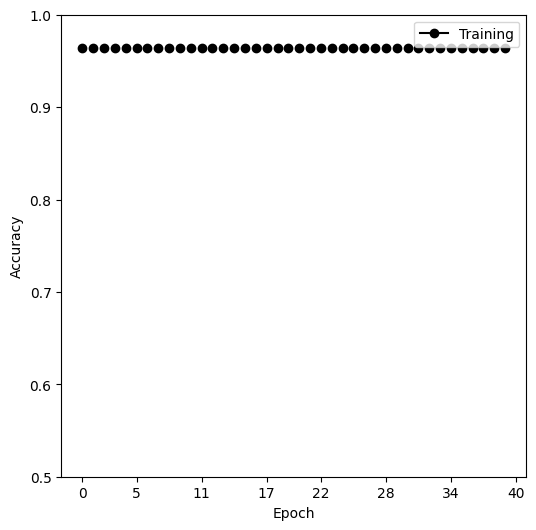

In [27]:
default_results = pd.read_csv(def_logger.experiment.metrics_file_path)
fig, ax = subplots(1,1, figsize=(6,6));
summary_plot(default_results, ax, col='accuracy', ylabel='Accuracy');
ax.set_ylim([0.5,1]);
ax.set_ylabel('Accuracy');
ax.set_xticks(np.linspace(0,40,8).astype(int));

In [31]:
# Constructing 50 vals for lambda
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1),
                                       np.log(1e-4),50))
# Logistic Regression
logit = LogisticRegression(penalty='l1',
                           C=1/lam_max,
                           solver='liblinear',
                           warm_start=True,
                           fit_intercept=True)

In [52]:
coefs = []
intercepts = []

for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)
logit.coef_

array([[-7.56996155e-01,  4.98129623e-03, -1.04313494e-05]])

In [53]:
# Removing extranneous dimension in coefs and intercept
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

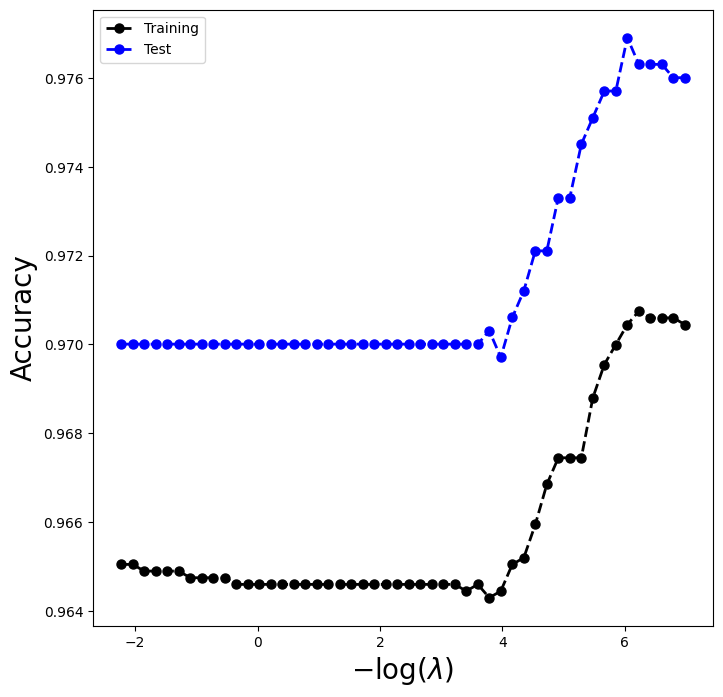

In [55]:
fig, axes = subplots(1, 1, figsize=(8,8))
for ((X_, Y_),
     data_,
     color) in zip([(X_train, Y_train),
                    (X_test, Y_test)],
                   ['Training', 'Test'],
                   ['black', 'blue']):
    linpred_ = np.dot(X_ , coefs.T) + intercepts[None, :]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    axes.plot(-np.log(lam_val / X_train.shape[0]), 
                accuracy_,
                '.--',
                color=color,
                markersize=13,
                linewidth=2,
                label=data_)
    axes.legend()
    axes.set_xlabel(r'$-\log(\lambda)$', fontsize=20)
    axes.set_ylabel('Accuracy', fontsize=20)